<a href="https://colab.research.google.com/github/akitim/SkillFactory_projects/blob/main/Project_5_SF_Scoring_Akimkin_Timofey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
## 1. Загрузка библиотек
---
---

In [1]:
import numpy as np # linear algebra
import pandas as pd 
import pandas_profiling # автоматизация EDA

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns # импорт графических библиотек

from sklearn import metrics as mt # импорт метрик модели

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

---
## 2. Загрузка данных
---
---

In [2]:
RANDOM_SEED = 42
!pip freeze > requirements.txt

In [3]:
# DATA_DIR = '/kaggle/input/sf-scoring/'
# DATA_DIR = '/content/sample_data'

DATA_DIR = 'https://raw.githubusercontent.com/akitim/datasets/main/Project%205/'

df_train = pd.read_csv(DATA_DIR +'/train.csv')
df_test = pd.read_csv(DATA_DIR +'/test.csv')
# sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

---
## 3. Первичный осмотр данных
---
---

In [4]:
# sample_submission.sample(5)

In [5]:
# sample_submission.shape

In [6]:
# sample_submission.info()

In [7]:
df_test.shape

(36349, 18)

---
## 4. EDA
---
---

#### Посмотрим распределение числовых признаков и их логарифмов

In [8]:
num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
cat_cols = ['education', 'first_time', 'sna', 'work_address', 'home_address', 'region_rating']
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

In [9]:
#для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем, где у нас тренировочные данные
df_test['sample'] = 0  # помечаем, где у нас тестовые данные
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем train и test

In [10]:
def draw_charts_for_numeric(data, target='default', plot_type='histplot', charts_in_row=3, \
                title='Распределение числовых переменных и их логарифмов\n',\
                fs=(20,20),\
                **kwargs):
    
    def chart_to_plot(data_, col, tgt, plt_fun, ax_c, is_log=False):
        # d = data_[[col, tgt]].dropna().copy()
        d = data_.dropna().copy()
    
        if is_log:
            d[col] = d[col].apply(lambda x: np.log(x + 1))
            
        if plt_fun == 'histplot':
            sns.histplot(d[col], kde=True, ax=ax_c)
        elif plt_fun == 'boxplot':
            sns.boxplot(x=tgt, y=col, data=d, ax=ax_c)
            ax_c.set_xlabel(col, fontsize=13)
            
    n_feat_to_plot = data.shape[1] - 1

    fig, ax = plt.subplots((n_feat_to_plot // charts_in_row + 1) * 2, charts_in_row, sharey=False, figsize=fs)
    fig.suptitle(title, fontsize=20);

    for i, feat in enumerate(data.columns):
        
        ax_curr = ax[2 * (i // 3), i % 3]    
        
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, ax_c=ax_curr)
        
        ax_curr.set_title(feat)
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)
            
        ax_curr = ax[2 * (i // 3) + 1, i % 3]    
       
        chart_to_plot(data_=data, tgt=target, col=feat, plt_fun=plot_type, is_log=True, ax_c=ax_curr)
        
        ax_curr.set_title(f'log({feat})')
        ax_curr.set_xlabel('')
        ax_curr.set_ylabel('')
        
        if feat==target: fig.delaxes(ax_curr)
        
    for axes in ax.flatten():
        if not(axes.has_data()):
            fig.delaxes(axes)

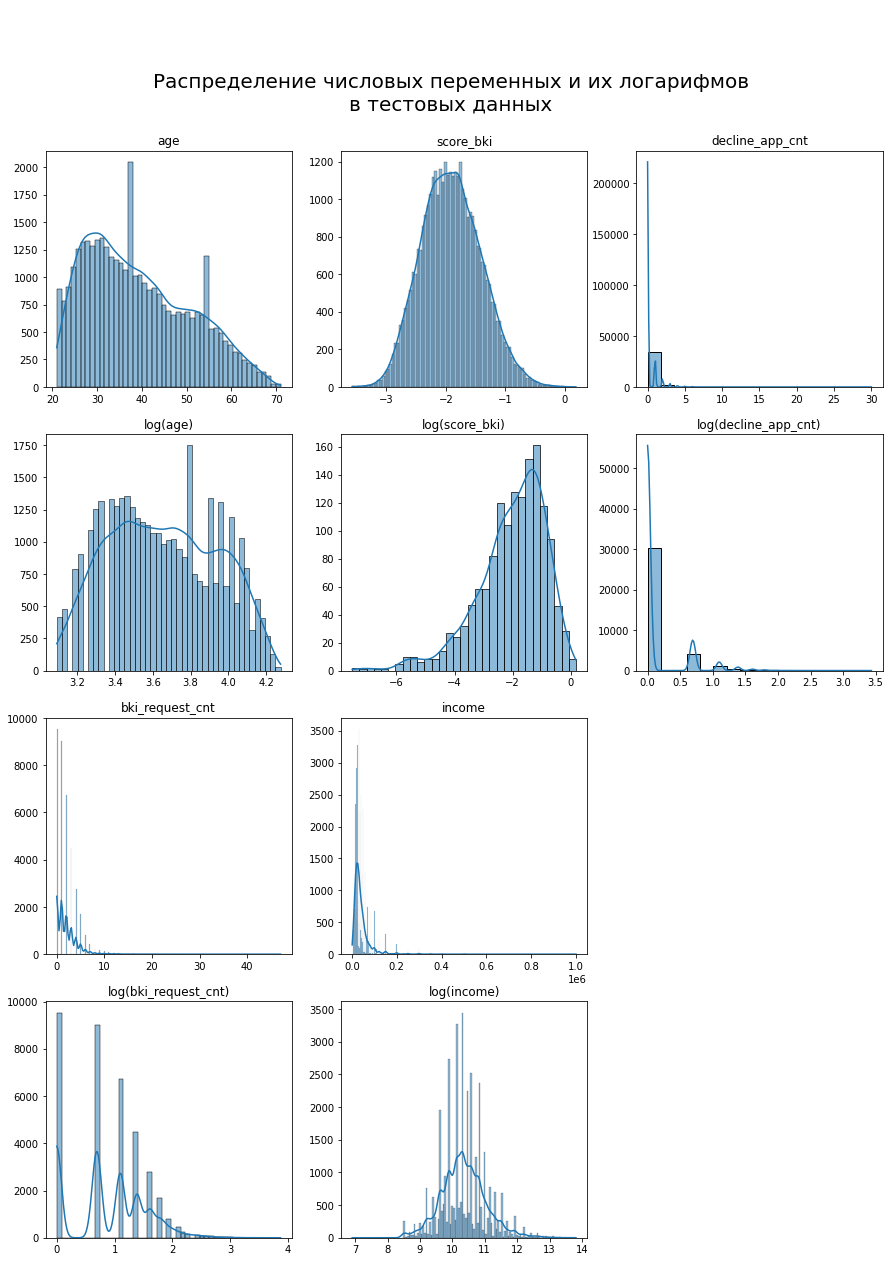

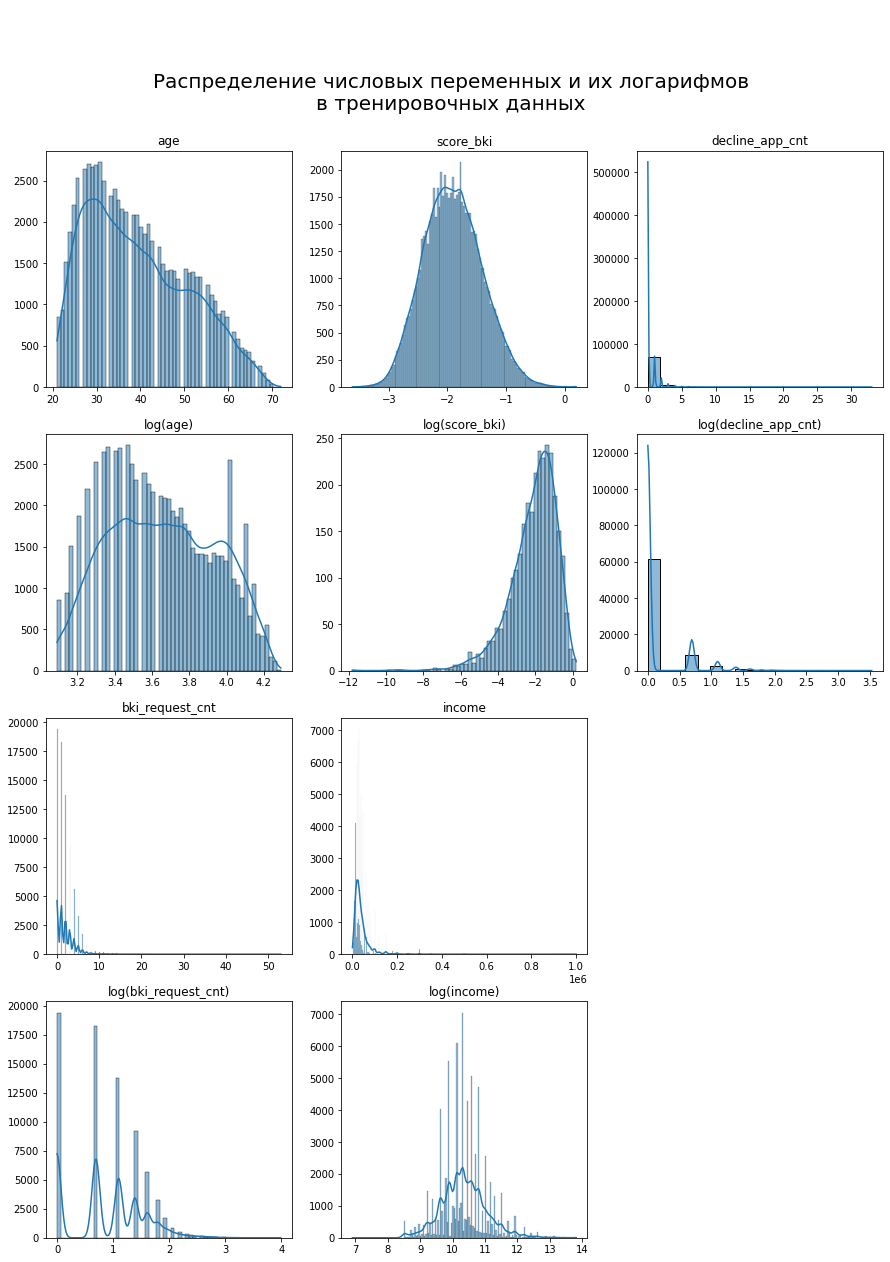

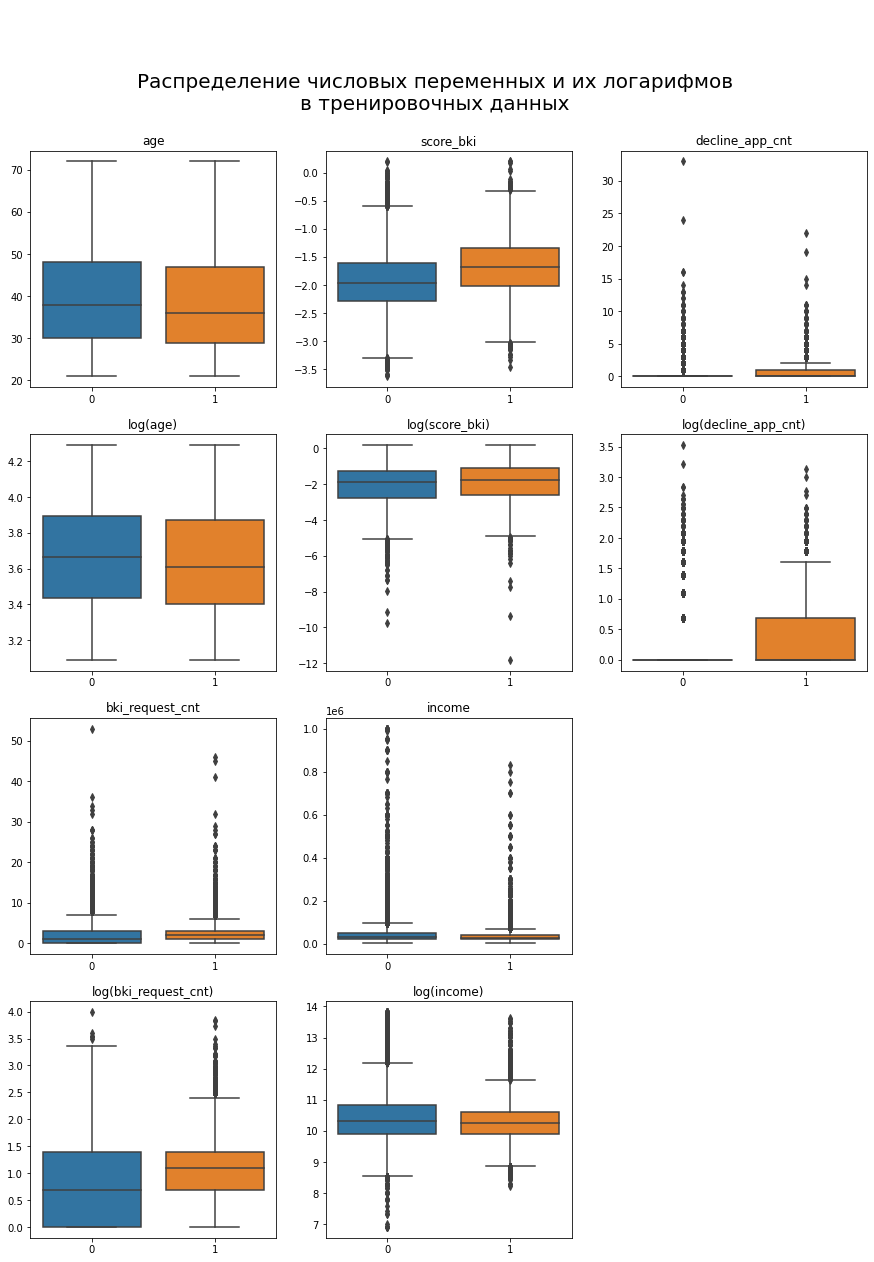

In [11]:
draw_charts_for_numeric(data=df_test[num_cols], plot_type='histplot', charts_in_row=3, \
                title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тестовых данных',\
                fs=(15, 20))

draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='histplot', charts_in_row=3, \
                title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тренировочных данных',\
                fs=(15, 20))

draw_charts_for_numeric(data=df_train[num_cols+['default']], plot_type='boxplot', charts_in_row=3, \
                title='\n\n\nРаспределение числовых переменных и их логарифмов\nв тренировочных данных',\
                fs=(15, 20))

In [12]:
# num_cols = ['age', 'score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income']
# n_col_fig = 3
# fig, ax = plt.subplots((len(num_cols) // n_col_fig + 1) * 2, n_col_fig, sharey=False, figsize=(20,20))
# fig.suptitle('Распределение числовых переменных и их логарифмов\nв тренировочных данных', fontsize=20);

# d = df_train[num_cols+['default']].dropna().copy()

# for i, cat in enumerate(num_cols+['default']):
    
#     ax_curr = ax[2* (i // 3), i % 3]    

#     sns.boxplot(y=cat, x='default', data=d, ax=ax_curr)
    
#     ax_curr.set_title(cat)
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')
    
#     if cat=='default': fig.delaxes(ax_curr)

#     ax_curr = ax[2*(i // 3) + 1, i % 3]    

#     d[cat] = d[cat].apply(lambda x: np.log(x + 1))
#     sns.boxplot(y=cat, x='default', data=d, ax=ax_curr)
    
#     ax_curr.set_title(f'log({cat})')
#     ax_curr.set_xlabel('')
#     ax_curr.set_ylabel('')
    
#     if cat=='default': fig.delaxes(ax_curr)
    
# for axes in ax.flatten():
#     if not(axes.has_data()):
#         fig.delaxes(axes)

In [13]:
# df_train.info()

In [14]:
# df_test.info()

есть пропуски в признаке education

In [15]:
df_train.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,sample
54041,99253,16APR2014,SCH,F,55,N,N,0,0,-2.473880,1,40,2,3,20000,1,4,N,0,1
70160,11003,18JAN2014,GRD,F,51,Y,Y,0,1,-1.788522,5,80,2,3,5000,1,4,N,0,1
61303,30847,06FEB2014,SCH,F,49,N,N,0,0,-2.065486,1,60,1,2,25000,4,3,N,0,1
40030,51039,27FEB2014,SCH,F,45,N,N,0,0,-1.541189,0,50,1,1,40000,1,4,N,0,1
6194,109285,30APR2014,UGR,M,25,Y,Y,0,0,-1.248407,1,50,1,2,45000,1,2,N,0,1


In [16]:
# pandas_profiling.ProfileReport(df_train)

In [17]:
data.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
sample                   2
default                  2
dtype: int64

In [18]:
old_cols = set(['client_id', 'education', 'sex', 'age', 'car', 'car_type',
       'decline_app_cnt', 'good_work', 'bki_request_cnt', 'home_address',
       'work_address', 'income', 'foreign_passport', 'default'])

new_cols = set(df_train.columns) - old_cols - set(['sample'])
print ('Новые признаки:\n', *new_cols)

Новые признаки:
 first_time score_bki app_date sna region_rating


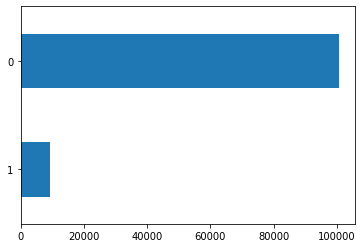

In [19]:
data['default'].value_counts(ascending=True).plot(kind='barh');

Наблюдается сильный дисбаланс классов: <br> 

In [20]:
print('соотношение недефолтных клиентов к дефолтным - 1 к',\
      round(data.default[data.default == 0].count() / data.default[data.default == 1].count()))

соотношение недефолтных клиентов к дефолтным - 1 к 11


---
##Заполнение пропусков
---
---

In [21]:
#заполняем пропуски в education случайным образом с распределением как в df_train 

edu_species = data['education'].dropna().unique()
edu_species_num = edu_species.shape[0]

#доля каждого значения среди всех значений признака education
weights = data[data['sample']==1]['education'].value_counts() / data[data['sample']==1]['education'].count()

data['education'] = data['education'].apply(
    lambda x: np.random.choice(edu_species, 1, p = weights)[0] if pd.isna(x) else x
)

---
## Обработка признаков
---
---



##### Логарифмирование признаков

In [22]:
#логарифмируем все числовые признаки кроме score_bki

cols_to_log = num_cols.copy()
cols_to_log.remove('score_bki')

# x + 1 - избегаем взятия логарифма от нуля
data[cols_to_log] = data[cols_to_log].apply(lambda x: np.log(x + 1))

##### Выявление выбросов

In [23]:
train_data = data.query('sample == 1')[num_cols]

#вычисляем 1й и 3й квартили и межквартильный интервал для тренировочного датасета
Q1 = train_data.quantile(0.25, axis=0)
Q3 = train_data.quantile(0.75, axis=0)

IQR = Q3 - Q1
lbound, ubound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

outliers = {}
for col in num_cols:

    outliers[col] = [data[(~data[col].between(lbound[col], ubound[col])) &
                              (data.default == 1)][col].count(),
                      
                     data[(~data[col].between(lbound[col], ubound[col])) &
                              (data.default == 0)][col].count(),
                    ]
    
    outliers[col] += [sum(outliers[col])]

outliers = pd.DataFrame(outliers, index=pd.MultiIndex.from_product([
                                    ['outliers'],
                                    ['default = 1',
                                     'default = 0',
                                     'total']]),
)

num_cols_w_outliers = \
    outliers.loc[
                 ('outliers', 'total'),
                 outliers.loc[('outliers', 'total'), :] != 0
    ].index
print ('\033[1m' + '===============================  ВЫБРОСЫ  ==================================' + '\033[0m\n')
display(outliers)

===============================  ВЫБРОСЫ  ==================================



age  score_bki  decline_app_cnt  bki_request_cnt  income
outliers default = 1    0        114             2667                4     177
         default = 0    0        421            16010               11    2432
         total          0        535            18677               15    2609

##### Добавляем новые признаки на основе выбросов:

***Описание добавить***


In [24]:
for col in num_cols_w_outliers:

    # создаем новый признак
    data[col + '_outliers'] = 0

    # маски для "верхних" и "нижних" выбросов
    mask_right = data[col] >= ubound[col]
    mask_left = data[col] <= lbound[col]

    data.loc[mask_right | mask_left, col + '_outliers'] = \
        outliers.loc[('outliers', 'total'), col]

    # подтягиваем выбросы к краям интервала с невыбросными значениями
    data.loc[mask_right, col] = ubound[col]
    data.loc[mask_left,  col] = lbound[col]

========================================================
#####  ***поработать с признаком 'app_date'***

##### Label и One-Hot encoding

In [25]:
# удаляем заведомо не влияющие признаки
data.drop(['client_id','app_date',], axis = 1, inplace=True)

In [26]:
data = pd.get_dummies(data, columns=['education'], dummy_na=False)

In [27]:
from sklearn import preprocessing as pp

label_enc = pp.LabelEncoder()

for col in bin_cols:
    data[col] = label_enc.fit_transform(data[col])
    
cat_cols_copy = cat_cols.copy()
cat_cols_copy.remove('education')

for col in cat_cols_copy:
    data[col] = label_enc.fit_transform(data[col])

In [28]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,score_bki_outliers,decline_app_cnt_outliers,bki_request_cnt_outliers,income_outliers,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,1,3.401197,1,1,0.0,0,-2.271884,1.386294,3,0,1,10.819798,0,3,0,0,0,0,18677,0,0,0,1,0,0,0
1,0,3.688879,0,0,0.0,0,-1.504999,1.098612,3,0,1,8.590378,3,2,0,0,0,0,18677,0,2609,0,0,0,1,0
2,1,3.931826,1,1,0.0,0,-1.691339,0.693147,3,0,1,10.308986,0,2,1,0,0,0,18677,0,0,0,0,0,0,1
3,1,4.043051,0,0,0.0,0,-2.374182,0.693147,2,0,1,9.741027,0,2,0,0,0,0,18677,0,0,0,0,0,1,0
4,0,3.663562,0,0,0.0,0,-2.487502,0.000000,6,1,2,11.695255,0,2,0,0,0,0,18677,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,0,3.828641,0,0,0.0,0,-1.792064,1.386294,3,0,1,9.741027,3,3,0,1,0,0,18677,0,0,0,1,0,0,0
110144,1,3.737670,1,1,0.0,0,-2.058029,0.693147,3,1,1,11.156265,0,3,0,1,0,0,18677,0,0,0,0,0,1,0
110145,1,3.465736,0,0,0.0,0,-1.512635,1.609438,6,1,2,10.714440,1,1,0,1,0,0,18677,0,0,0,0,0,1,0
110146,0,3.401197,0,0,0.0,1,-1.479334,1.386294,3,0,2,9.472782,1,2,0,1,1,0,18677,0,0,0,0,0,1,0


##### Стандартизация признаков

*стандартизируем объединенный датасет data по параметрам тренировочной выборки*

In [29]:
std_scaler = pp.StandardScaler()

std_scaler.fit(data[data['sample'] == 1].drop(['sample', 'default'], axis=1))

cols_for_scaling = list(data.columns)
cols_for_scaling.remove('default')
cols_for_scaling.remove('sample')

data[cols_for_scaling] = std_scaler.transform(data.drop(['sample', 'default'], 
                                                        axis=1))

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 26 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   sex                       110148 non-null  float64
 1   age                       110148 non-null  float64
 2   car                       110148 non-null  float64
 3   car_type                  110148 non-null  float64
 4   decline_app_cnt           110148 non-null  float64
 5   good_work                 110148 non-null  float64
 6   score_bki                 110148 non-null  float64
 7   bki_request_cnt           110148 non-null  float64
 8   region_rating             110148 non-null  float64
 9   home_address              110148 non-null  float64
 10  work_address              110148 non-null  float64
 11  income                    110148 non-null  float64
 12  sna                       110148 non-null  float64
 13  first_time                110148 non-null  f

In [31]:
data

,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default,score_bki_outliers,decline_app_cnt_outliers,bki_request_cnt_outliers,income_outliers,education_ACD,education_GRD,education_PGR,education_SCH,education_UGR
0,1.135458,-0.891463,1.44194,2.065998,0.0,-0.444356,-0.739002,0.772773,-0.515157,-1.090749,-0.719441,0.711426,-0.652652,1.222978,-0.419998,0,0,-0.06913,0.0,-0.011044,-0.156623,-0.051339,1.461453,-0.132008,-1.057146,-0.392672
1,-0.880702,0.117680,-0.69351,-0.484028,0.0,-0.444356,0.807013,0.335413,-0.515157,-1.090749,-0.719441,-2.594992,2.017303,0.232345,-0.419998,0,0,-0.06913,0.0,-0.011044,6.384758,-0.051339,-0.684250,-0.132008,0.945943,-0.392672
2,1.135458,0.969897,1.44194,2.065998,0.0,-0.444356,0.431358,-0.281012,-0.515157,-1.090749,-0.719441,-0.046152,-0.652652,0.232345,2.380963,0,0,-0.06913,0.0,-0.011044,-0.156623,-0.051339,-0.684250,-0.132008,-1.057146,2.546654
3,1.135458,1.360060,-0.69351,-0.484028,0.0,-0.444356,-0.945233,-0.281012,-1.281110,-1.090749,-0.719441,-0.888483,-0.652652,0.232345,-0.419998,0,0,-0.06913,0.0,-0.011044,-0.156623,-0.051339,-0.684250,-0.132008,0.945943,-0.392672
4,-0.880702,0.028869,-0.69351,-0.484028,0.0,-0.444356,-1.173682,-1.334798,1.782702,0.804527,0.730226,2.009802,-0.652652,0.232345,-0.419998,0,0,-0.06913,0.0,-0.011044,-0.156623,-0.051339,1.461453,-0.132008,-1.057146,-0.392672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110143,-0.880702,0.607943,-0.69351,-0.484028,0.0,-0.444356,0.228299,0.772773,-0.515157,-1.090749,-0.719441,-0.888483,2.017303,1.222978,-0.419998,1,0,-0.06913,0.0,-0.011044,-0.156623,-0.051339,1.461453,-0.132008,-1.057146,-0.392672
110144,1.135458,0.288829,1.44194,2.065998,0.0,-0.444356,-0.307878,-0.281012,-0.515157,0.804527,-0.719441,1.210434,-0.652652,1.222978,-0.419998,1,0,-0.06913,0.0,-0.011044,-0.156623,-0.051339,-0.684250,-0.132008,0.945943,-0.392672
110145,1.135458,-0.665072,-0.69351,-0.484028,0.0,-0.444356,0.791620,1.112016,1.782702,0.804527,0.730226,0.555170,0.237333,-0.758287,-0.419998,1,0,-0.06913,0.0,-0.011044,-0.156623,-0.051339,-0.684250,-0.132008,0.945943,-0.392672
110146,-0.880702,-0.891463,-0.69351,-0.484028,0.0,2.250446,0.858753,0.772773,-0.515157,-1.090749,0.730226,-1.286314,0.237333,0.232345,-0.419998,1,1,-0.06913,0.0,-0.011044,-0.156623,-0.051339,-0.684250,-0.132008,0.945943,-0.392672


---
## Построение модели
---
---

In [32]:
# Выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample', 'default'], axis=1)

y = train_data['default'].values  # наш таргет
X = train_data.drop(['default'], axis=1)

In [33]:
# Воспользуемся функцией train_test_split для разбивки тестовых данных
from sklearn.model_selection import train_test_split

# выделим 20% данных на валидацию
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# test_data.columns

In [35]:
# X_train.columns

In [36]:
# X_valid.columns

In [37]:
# проверяем
# test_data.shape, train_data.shape, X.shape, X_train.shape, X_valid.shape

((36349, 24), (73799, 25), (73799, 24), (59039, 24), (14760, 24))

##### Логистическая регрессия

In [38]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='liblinear', max_iter=1000,
                            class_weight='balanced',
                            fit_intercept=True,
                            random_state=RANDOM_SEED)

logreg.fit(X_train, y_train)

y_proba = logreg.predict_proba(X_valid)[:, 1]
y_pred = logreg.predict(X_valid)

##### Метод k ближайших соседей

In [88]:
from sklearn.neighbors import KNeighborsClassifier

# реализуем метод k ближайших соседей
KNN_num = 10
KNN = KNeighborsClassifier(n_neighbors=KNN_num)
KNN.fit(X_train, y_train)

y_pred_knn = KNN.predict(X_valid)
y_proba_knn = KNN.predict_proba(X_valid)[:, 1]

##### Решающие деревья

In [97]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(class_weight='balanced', random_state=RANDOM_SEED)
tree.fit(X_train, y_train)

y_pred_tree = tree.predict(X_valid)
y_proba_tree = tree.predict_proba(X_valid)[:, 1]

In [98]:
class ModelMetrics:

# =======================================================================
    def __init__(self, y_true, y_pred, y_proba):
        self.y_true = y_true
        self.y_pred = y_pred
        self.y_proba = y_proba

# =======================================================================
    def plot_roc_curve(self, model_label='Модель'):
        from sklearn.metrics import roc_auc_score, roc_curve

        roc_auc = roc_auc_score(self.y_true, self.y_proba)
        FPR, TPR, THRESHOLDS = roc_curve(self.y_true, self.y_proba)

        plt.figure(figsize=(8,5))
        plt.plot([0, 1], label='Случайный выбор', linestyle='-.')
        plt.plot(FPR, TPR, label ='Вид модели: ' + model_label)
        plt.title(f"\nКривая ROC (ROC's AUC =  {roc_auc:0.3f})", fontsize=14)
        plt.ylabel('Доля истинноположительных предсказаний\n(True Positive Rate)')
        plt.xlabel('Доля ложноположительных предсказаний\n(False Positive Rate)')
        plt.legend(loc = 'upper left')
        plt.show()

# =======================================================================
    def plot_precision_recall_curve(self, model_label='Модель'):
        from sklearn.metrics import precision_recall_curve

        prec, rec, thresholds = precision_recall_curve(self.y_true, self.y_proba)
        
        AUC = 0.5 * (rec[:-1] - rec[1:]) @ (prec[:-1] + prec[1:])

        plt.figure(figsize=(8,5))
        plt.plot(rec, prec, label = 'Вид модели: ' + model_label)
        plt.title(f"\n\nКривая Precision - Recall (PR's AUC =  {AUC:0.3f})", fontsize=18)
        plt.ylabel('Точность\n(Precision)', fontsize=13)
        plt.xlabel('Полнота\n(Recall)', fontsize=13)
        plt.legend(loc = 'upper right')
        plt.show()

# =======================================================================
    def print_metrics(self):
        from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score,\
            precision_score, recall_score, roc_auc_score
        
        metrics_ = {'Accuracy': [accuracy_score(self.y_true, self.y_pred)],
                    'Balanced accuracy': [balanced_accuracy_score(self.y_true, self.y_pred)],
                    'Precision':  [precision_score(self.y_true, self.y_pred)],
                    'Recall': [recall_score(self.y_true, self.y_pred)],
                    'F1-score': [f1_score(self.y_true, self.y_pred)],
                    "ROC's AUC": [roc_auc_score(self.y_true, self.y_proba)]}

        print('\n\n' + '\033[1m' + \
              '===============================  МЕТРИКИ  ==============================' + \
              '\033[1m')
        display(pd.DataFrame(metrics_, index=['']))
        return None

# =======================================================================
    def conf_matrix(self):

        from sklearn.metrics import confusion_matrix

        ax = sns.heatmap(confusion_matrix(self.y_true, self.y_pred),
                    annot=True, fmt='.0f', linewidth=2, cmap='Blues',
                    annot_kws={'size': 20},
                    xticklabels=['Не дефолт', 'Дефолт'],
                    yticklabels=['Не дефолт', 'Дефолт']
                    )
        
        ax.tick_params(left=False, bottom=False) # удаляем штрихи

        annot_labels = ['TN', 'FP', 'FN', 'TP']
        for i, t in enumerate(ax.texts):
            t.set_text(annot_labels[i] + '\n' + t.get_text())
        
        ax.set_xlabel(r'$\ Предсказанные $', fontsize=18, color= '#01153E',
                      labelpad=20, weight='bold', rotation = 0)
        ax.set_ylabel(r'$\ Истинные $', fontsize=18, color='#01153E',
                      labelpad=25, rotation = 90)
        
        plt.xticks(rotation=-45, fontsize=11, weight='bold')
        plt.yticks(rotation=45, fontsize=11, weight='bold')

        plt.title('\nМатрица ошибок\n', fontsize=20)
        return None #confusion_matrix(self.y_true, self.y_pred)

In [71]:
model_metrics = ModelMetrics(y_valid, y_pred, y_proba)



===============================  МЕТРИКИ  ==============================


,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.65935,0.665781,0.217476,0.67433,0.328884,0.734704


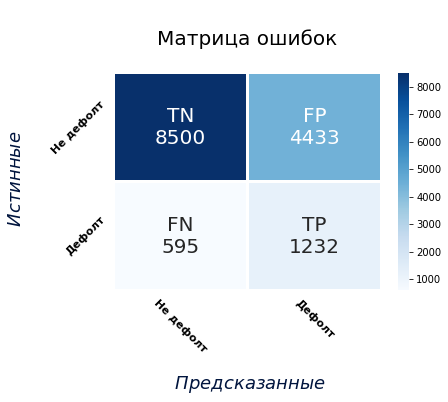

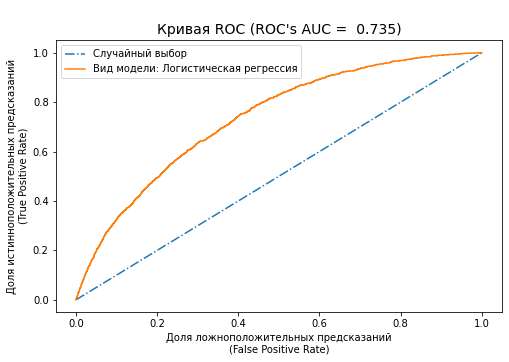

In [72]:
model_metrics.print_metrics()
model_metrics.conf_matrix()
model_metrics.plot_roc_curve(model_label='Логистическая регрессия')

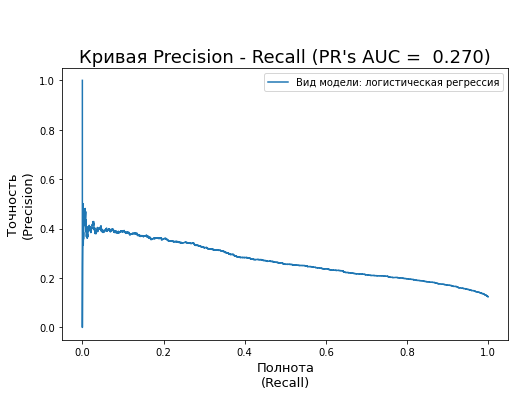

In [52]:
model_metrics.plot_precision_recall_curve(model_label='логистическая регрессия')

In [89]:
model_metrics_knn = ModelMetrics(y_valid, y_pred, y_proba)



===============================  МЕТРИКИ  ==============================


,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.65935,0.665781,0.217476,0.67433,0.328884,0.734704


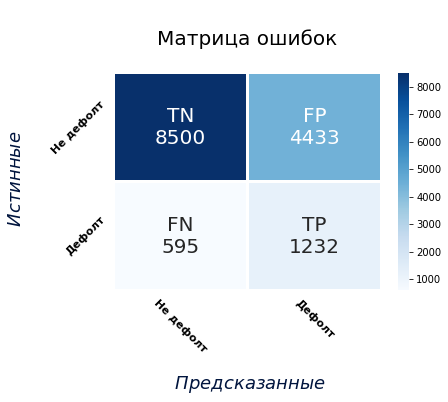

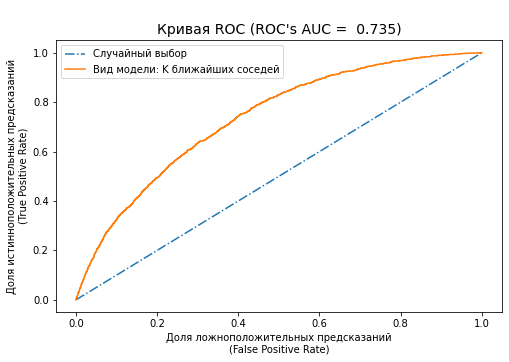

In [90]:
model_metrics_knn.print_metrics()
model_metrics_knn.conf_matrix()
model_metrics_knn.plot_roc_curve(model_label='K ближайших соседей')

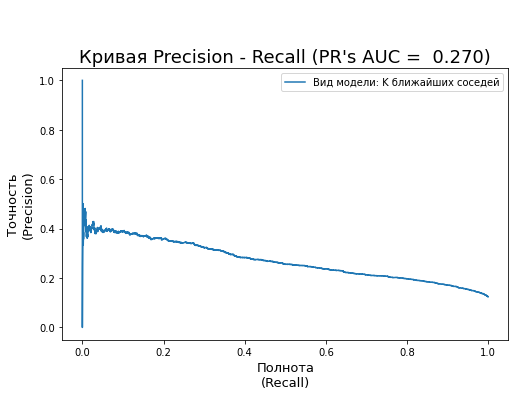

In [93]:
model_metrics_knn.plot_precision_recall_curve(model_label='K ближайших соседей')

In [99]:
model_metrics_tree = ModelMetrics(y_valid, y_pred_tree, y_proba_tree)



===============================  МЕТРИКИ  ==============================


,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.79939,0.538883,0.191513,0.192666,0.192087,0.538883


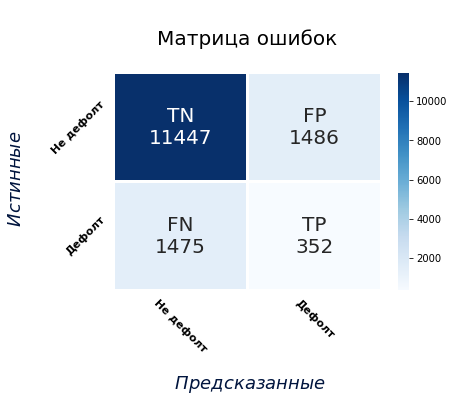

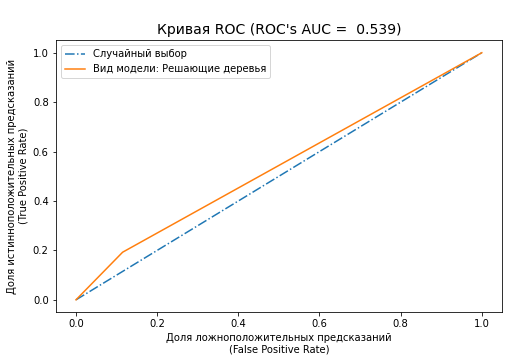

In [100]:
model_metrics_tree.print_metrics()
model_metrics_tree.conf_matrix()
model_metrics_tree.plot_roc_curve(model_label='Решающие деревья')

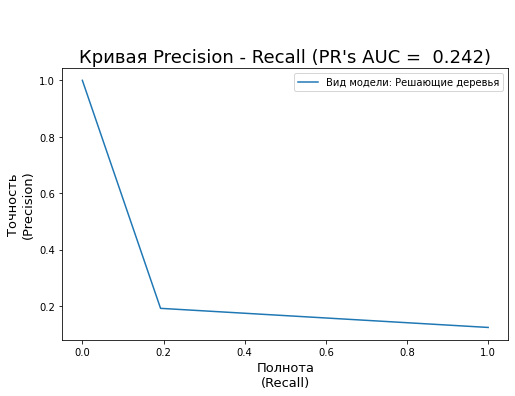

In [102]:
model_metrics_tree.plot_precision_recall_curve(model_label='Решающие деревья')

---
## Оптимизация гиперпараметров
---
---

In [75]:
from sklearn.model_selection import GridSearchCV

# инициализируем оптимизацию гиперпараметров GridSearch
model_opt = LogisticRegression(random_state = RANDOM_SEED)

iter_ = 1000
epsilon_stop = 1e-5
C = np.logspace(-3, 2, 5)

# определяем сетку параметров для оптимизации
param_grid = [
    {'C': C,
     'penalty': ['l1'], 
     'solver': ['liblinear'], 
     'class_weight':['balanced'], 
     'multi_class': ['ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'C': C,
     'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['balanced'], 
     'multi_class': ['ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]},
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight': ['balanced'], 
     'multi_class': ['ovr'], 
     'max_iter':[iter_],
     'tol':[epsilon_stop]}
]

# запускаем оптимизацию
gridsearch = GridSearchCV(model, param_grid, scoring='f1',
                          n_jobs=-1, cv=15, refit=True)
gridsearch.fit(X_valid, y_valid)
model_opt = gridsearch.best_estimator_

##печатаем параметры
best_parameters = model.get_params()

for param_name in sorted(best_parameters.keys()):
        # print('\t%s: %r' % (param_name, best_parameters[param_name]))
        print(f'\t{param_name}: {best_parameters[param_name]}')

	C: 0.001
	class_weight: balanced
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: ovr
	n_jobs: None
	penalty: l2
	random_state: 42
	solver: sag
	tol: 0.001
	verbose: 0
	warm_start: False


In [76]:
y_pred_opt = model_opt.predict(X_valid)
y_proba_opt = model_opt.predict_proba(X_valid)[:, 1]

In [77]:
model_metrics_opt = ModelMetrics(y_valid, y_pred_opt, y_proba_opt)



===============================  МЕТРИКИ  ==============================


,Accuracy,Balanced accuracy,Precision,Recall,F1-score,ROC's AUC
,0.65935,0.665781,0.217476,0.67433,0.328884,0.734704


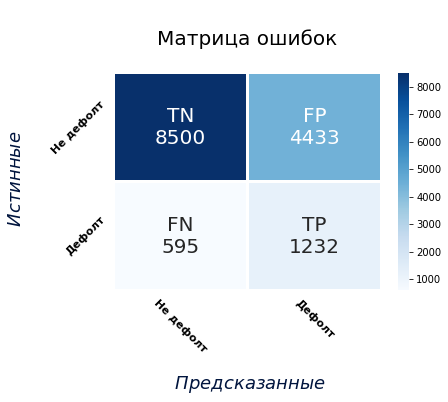

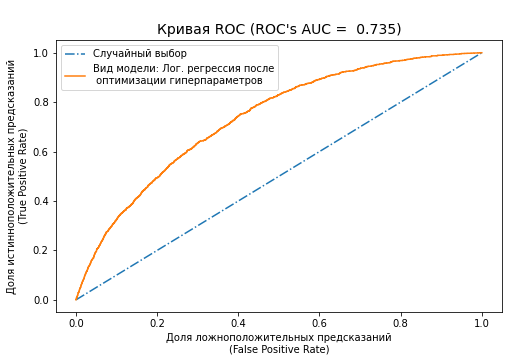

In [78]:
model_metrics.print_metrics()
model_metrics.conf_matrix()
model_metrics.plot_roc_curve(model_label='Лог. регрессия после\n оптимизации гиперпараметров')

> Оптимизация гиперпараметров модели не дала улучшение метрик

# Отправка результатов

In [79]:
predict_submission = logreg.predict(test_data)

In [80]:
# sample_submission['default'] = predict_submission
# sample_submission.to_csv('submission.csv', index=False)
# sample_submission.head(10)

In [81]:
# !kaggle competitions submit Timofey Akimkin -c sf-scoring -f submission.csv -m "Message"
# !kaggle competitions submit your-competition-name -f submission.csv -m 'My submission message'